In [1]:
from fastai.text import *
import pandas as pd
import string
bs = 32

In [2]:
path = Path(r"/media/loschen/NEWDATA/data/molecule_images")
df = pd.read_csv(path/'molecule_images.csv')
df.shape

(133247, 13)

In [3]:
#remove charged species
df = df.loc[~ (df['SMILES'].str.contains("+",regex=False) | df['SMILES'].str.contains("-",regex=False))]
df

,Unnamed: 0,inchikey,SMILES,NumAliphaticRings,CalcNumAromaticRings,CalcNumBridgeheadAtoms,CalcNumRotatableBonds,CalcNumHBA,CalcNumHBD,CalcNumRings,MolLogP,GetFormalCharge,MolMR
0,0,VNWKTOKETHGBQD-UHFFFAOYSA-N,C,0,0,0,0,0,0,0,0.63610,0,6.7310
1,1,QGZKDVFQNNGYKY-UHFFFAOYSA-N,N,0,0,0,0,1,1,0,0.16200,0,5.0221
2,2,XLYOFNOQVPJJNP-UHFFFAOYSA-N,O,0,0,0,0,0,0,0,-0.82470,0,3.6138
3,3,HSFWRNGVRCDJHI-UHFFFAOYSA-N,C#C,0,0,0,0,0,0,0,0.24940,0,9.8900
4,4,LELOWRISYMNNSU-UHFFFAOYSA-N,C#N,0,0,0,0,1,0,0,0.13978,0,6.6700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133233,133233,LPNIJQZZJAITJM-UHFFFAOYSA-N,C1C2CC3C4CC3(O2)C14,5,0,3,0,1,0,5,1.18370,0,31.9250
133234,133234,BXTBRKSXZFAABS-UHFFFAOYSA-N,C1C2OC3C4CC3(O2)C14,5,0,3,0,2,0,5,0.52010,0,28.6910
133235,133235,BGOAASCIAIBBKN-UHFFFAOYSA-N,C1C2OC3C4CC13C4O2,5,0,3,0,2,0,5,0.52010,0,28.6910
133240,133240,IBUPBUYMKIPOKE-UHFFFAOYSA-N,C1C2C3C2C2C4CC12C43,8,0,7,0,0,0,8,1.51820,0,32.6070


In [4]:
smi_vocab=list(set("".join(list(df.SMILES))))+[BOS,EOS]
print(smi_vocab)

['/', '(', '\\', 'H', ')', '5', '[', 'n', 'F', '2', '=', 'c', '4', 'C', '#', '1', '3', 'o', 'N', '.', ']', 'O', 'xxbos', 'xxeos']


'xxbos'

In [62]:
class SmilesTokenizer(BaseTokenizer):
    "Tokenize Smiles."
    def tokenizer(self, t:str) -> List[str]:
        #print("t: {:s}".format(t))
        res = []
        i = 0
        while i < len(t):
            if t[i]==' ': 
                i += 1
                continue
            if t[i:].startswith(BOS):
                res.append(BOS)
                i += len(BOS)
            elif t[i:].startswith(EOS):
            #    res.append(EOS)
                i += len(EOS)
            else:
                res.append(t[i])
                i += 1
        #print(res)
        return res
    def add_special_cases(self, toks:Collection[str]): pass
    
sm = SmilesTokenizer('smiles')
tokens = sm.tokenizer(BOS+' ccX'+EOS)
tokens


['xxbos', 'c', 'c', 'X']

In [63]:
#itos = [UNK, BOS, EOS] + smi_vocab
#vocab=Vocab(itos)
tokenizer=Tokenizer(SmilesTokenizer, pre_rules=[], post_rules=[])
tp = TokenizeProcessor(tokenizer=tokenizer,include_bos=True, include_eos=True, mark_fields=False)
np = NumericalizeProcessor(vocab=Vocab.create(smi_vocab, max_vocab=1000, min_freq=0))
np = NumericalizeProcessor(vocab=Vocab(smi_vocab))
processors = [tp,np]

In [64]:
tl = TextList.from_df(df, path,cols=2,processor=processors)
tl

TextList (104306 items)
C,N,O,C#C,C#N
Path: /media/loschen/NEWDATA/data/molecule_images

### Language model

In [231]:
data = tl.split_by_rand_pct(0.1).label_for_lm().databunch(bs=bs)
data

TextLMDataBunch;

Train: LabelList (93876 items)
x: LMTextList
xxbos C,xxbos O,xxbos C # C,xxbos C # N,xxbos C C
y: LMLabelList
,,,,
Path: /media/loschen/NEWDATA/data/molecule_images;

Valid: LabelList (10430 items)
x: LMTextList
xxbos C O C C 1 ( N ) C N C 1 = O,xxbos O = C 1 C C C 2 C C 2 C N 1,xxbos C C # C c 1 o n c c 1 N,xxbos C C ( O ) C 1 C 2 C C ( = O ) N 2 1,xxbos C C ( C # N ) C 1 ( O ) C C C 1
y: LMLabelList
,,,,
Path: /media/loschen/NEWDATA/data/molecule_images;

Test: None

### Regression model

In [224]:
labels_cols = ['CalcNumRings','CalcNumRotatableBonds']
#labels_cols = ['MolLogP','MolMR']
data = tl.split_by_rand_pct(0.1).label_from_df(cols=labels_cols,label_cls=FloatList).databunch(bs=bs)
type(data)

fastai.text.data.TextClasDataBunch

In [153]:
doc(TextClasDataBunch)

In [192]:
data.show_batch()

idx,text
0,C ) = O xxbos C C ( = O ) C # N xxbos N # C C ( = N ) N xxbos C # C C ( N ) = O xxbos N = C ( N ) C = O xxbos N C ( = O ) C = O xxbos C # C C ( C ) C xxbos C C ( C )
1,N ) n 1 xxbos C C c 1 c o c ( O ) n 1 xxbos C N c 1 c [ n H ] c ( C ) n 1 xxbos C N c 1 c [ n H ] c ( N ) c 1 xxbos C N c 1 c [ n H ] c ( O ) c 1 xxbos C N c 1
2,xxbos C C ( C # N ) C C C # N xxbos C # C C N C ( C ) C # N xxbos C # C C ( C ) N C C # N xxbos C C ( C # N ) N C C # N xxbos C # C C O C ( C ) C # C xxbos C # C C
3,C C 1 C O C O 1 xxbos N # C C C 1 O C C O 1 xxbos O = C C C 1 = C C C C 1 xxbos O = C C C 1 = C C O C 1 xxbos O = C C C 1 = N C C O 1 xxbos O = C N C 1 = C C C
4,C 2 O C C 2 C O 1 xxbos C 1 C C 2 C O C 2 C O 1 xxbos C 1 O C C 2 O C C 2 O 1 xxbos C # C C C 1 C 2 C C C 1 2 xxbos C # C C C 1 C 2 C O C 1 2 xxbos N # C C C 1


In [193]:
v = data.valid_ds.vocab
v.itos

['/',
 '(',
 '\\',
 'H',
 ')',
 '5',
 '[',
 'n',
 'F',
 '2',
 '=',
 'c',
 '4',
 'C',
 '#',
 '1',
 '3',
 'o',
 'N',
 '.',
 ']',
 'O',
 'xxbos',
 'xxeos']

In [178]:
x,y = next(iter(data.train_dl))

x is 2D and of shape (batch_size, max_seq_length), as embedding is done later

In [207]:
x.shape

torch.Size([32, 28])

In [208]:
data.train_ds.vocab.textify([0])

'/'

In [219]:
data.train_ds.vocab.textify(x[1])

'( ( ( ( ( ( xxbos C C 1 2 C ( O ) C 3 ( O ) C 1 4 O C 2 3 4'

In [194]:
v.textify(x[1]).replace(' ','')

'((((((xxbosCC12C(O)C3(O)C14OC234'

In [220]:
example = x[:10,:].cpu()
texts = pd.DataFrame([data.train_ds.vocab.textify(l).split(' ') for l in example])
texts

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,xxbos,O,=,c,1,[,n,H,],c,...,c,(,=,O,),[,n,H,],1
1,(,(,(,(,(,(,xxbos,C,C,1,...,O,),C,1,4,O,C,2,3,4
2,(,(,(,(,(,(,(,xxbos,N,c,...,c,(,=,O,),[,n,H,],1
3,(,(,(,(,(,(,(,xxbos,C,C,...,),C,2,(,C,),N,C,1,2
4,(,(,(,(,(,(,(,xxbos,C,C,...,C,(,C,1,=,O,),C,2,3
5,(,(,(,(,(,(,(,xxbos,C,#,...,C,3,4,O,C,2,3,C,1,4
6,(,(,(,(,(,(,(,xxbos,C,C,...,C,(,=,O,),C,1,C,3,2
7,(,(,(,(,(,(,(,(,xxbos,O,...,),c,(,O,),[,n,H,],1
8,(,(,(,(,(,(,(,(,xxbos,O,...,C,2,C,3,C,C,1,C,3,2
9,(,(,(,(,(,(,(,(,xxbos,C,...,C,1,(,C,C,1,),C,2,3


In [221]:
nv = len(v.itos); nv
nh=64

In [22]:
class SmilesModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.GRU(nh, nh, 2, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(2, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [197]:
data

TextLMDataBunch;

Train: LabelList (93876 items)
x: LMTextList
xxbos C,xxbos N,xxbos C # C,xxbos C = O,xxbos C C
y: LMLabelList
,,,,
Path: /media/loschen/NEWDATA/data/molecule_images;

Valid: LabelList (10430 items)
x: LMTextList
xxbos C C ( O ) C 1 ( C ) C C = C C 1,xxbos C C 1 2 C C C ( C 1 = O ) C 2 O,xxbos C C C 1 C = C ( C ) C 2 N C 1 2,xxbos N C ( = O ) O c 1 c o c n 1,xxbos C C 1 C C N 1 C ( = O ) C = O
y: LMLabelList
,,,,
Path: /media/loschen/NEWDATA/data/molecule_images;

Test: None

In [230]:
#https://docs.fast.ai/text.learner.html#language_model_learner
#learn = Learner(data, Model(), metrics=accuracy)
#learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False,metrics=[rmse])
#learn = learn.to_fp16(clip=0.1)
learn = language_model_learner(data, AWD_LSTM)
#learn = language_model_learner(data, AWD_LSTM,drop_mult=0.5,pretrained=False)
learn.summary()

AttributeError: backwards

https://medium.com/mlreview/understanding-building-blocks-of-ulmfit-818d3775325b

In [223]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(24, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(24, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=24, bias=True)
    (output_dp): RNNDropout()
  )
)

In [226]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(24, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(24, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e

In [80]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


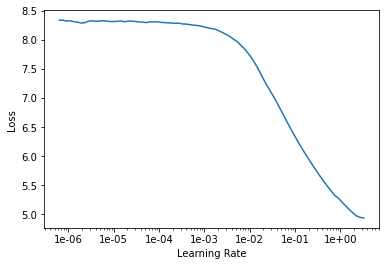

In [39]:
learn.recorder.plot()

In [81]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.538173,1.259675,0.568394,00:51
1,1.442617,1.227715,0.567302,00:51
2,1.368289,1.170785,0.589907,00:51


In [82]:
learn.save('smiles_lm')
learn.save_encoder('smiles_ln_encoder')

In [232]:
learn.load('smiles_lm')

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	Missing key(s) in state_dict: "0.module.encoder.weight", "0.module.encoder_dp.emb.weight", "0.module.rnns.0.weight_hh_l0_raw", "0.module.rnns.0.module.weight_ih_l0", "0.module.rnns.0.module.weight_hh_l0", "0.module.rnns.0.module.bias_ih_l0", "0.module.rnns.0.module.bias_hh_l0", "0.module.rnns.1.weight_hh_l0_raw", "0.module.rnns.1.module.weight_ih_l0", "0.module.rnns.1.module.weight_hh_l0", "0.module.rnns.1.module.bias_ih_l0", "0.module.rnns.1.module.bias_hh_l0", "0.module.rnns.2.weight_hh_l0_raw", "0.module.rnns.2.module.weight_ih_l0", "0.module.rnns.2.module.weight_hh_l0", "0.module.rnns.2.module.bias_ih_l0", "0.module.rnns.2.module.bias_hh_l0", "1.layers.0.weight", "1.layers.0.bias", "1.layers.0.running_mean", "1.layers.0.running_var", "1.layers.2.weight", "1.layers.2.bias", "1.layers.4.weight", "1.layers.4.bias", "1.layers.4.running_mean", "1.layers.4.running_var", "1.layers.6.weight", "1.layers.6.bias". 
	Unexpected key(s) in state_dict: "0.encoder.weight", "0.encoder_dp.emb.weight", "0.rnns.0.weight_hh_l0_raw", "0.rnns.0.module.weight_ih_l0", "0.rnns.0.module.weight_hh_l0", "0.rnns.0.module.bias_ih_l0", "0.rnns.0.module.bias_hh_l0", "0.rnns.1.weight_hh_l0_raw", "0.rnns.1.module.weight_ih_l0", "0.rnns.1.module.weight_hh_l0", "0.rnns.1.module.bias_ih_l0", "0.rnns.1.module.bias_hh_l0", "0.rnns.2.weight_hh_l0_raw", "0.rnns.2.module.weight_ih_l0", "0.rnns.2.module.weight_hh_l0", "0.rnns.2.module.bias_ih_l0", "0.rnns.2.module.bias_hh_l0", "1.decoder.weight", "1.decoder.bias". 

In [227]:
learn.predict('CC', n_words=20)

TypeError: analyze_pred() got an unexpected keyword argument 'n_words'

In [228]:
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
def getMolecule(startt):
    #p = learn.beam_search(startt, n_words=20, beam_sz=200)
    p = learn.predict('CC', n_words=20)
    p = p.replace(' ','')
    p = p[:p.index(BOS)]
    print(p)
    return Chem.MolFromSmiles(p)
    

In [229]:
getMolecule('O')

TypeError: analyze_pred() got an unexpected keyword argument 'n_words'

In [41]:
interp = TextClassificationInterpretation.from_learner(learn)
#https://forums.fast.ai/t/difference-in-result-during-inference-when-using-learn-get-preds-or-learn-predict/33740/3
#learn.get_preds(DatasetType.Valid)


In [30]:
learn.predict??

In [149]:
learn.show_results(rows=20)

text,target,pred
xxbos C C 1 ( O ) C 2 C O C O C 2 1 xxbos O = C,C 1 2 C C 3 C C 1 O C 3 2 xxbos C # C C ( O,C 1 C C C C C C 1 C xxbos 3 xxbos xxbos C C C C 1 C
c 1 c c n ( C ) c 1 C xxbos C C C 1 N C ( C,) C 1 N O xxbos N # C C 1 = C C C ( = O ) C,) C 1 C C xxbos C # C C 1 C C C C ( C O ) C
# N xxbos C # C C ( C ) C ( = O ) N ( C ) C,xxbos O = C C c 1 n c c n n 1 xxbos C O c 1 c c,1 C = C C 1 1 c c c ( c 1 xxbos C C C 1 c c
O 2 xxbos C # C C 1 = C C C ( = O ) C C 1 xxbos,C C 1 C 2 C 3 C ( = O ) N 1 C 3 2 C xxbos C,C C 1 C C C C C C C O ) C 1 xxbos 2 xxbos xxbos xxbos C
C ( = O ) O xxbos C O C 1 ( C ) C 2 C C 1 C,= O xxbos C C 1 ( O ) C 2 C = C C 1 N 2 xxbos C,2 xxbos O xxbos C C 1 C C ) C C C C O C 1 xxbos C xxbos
C ) c 1 N xxbos O = C 1 C C C 2 ( O ) C C 2,2 C 1 xxbos N C 1 C O c 2 n n o c 2 1 xxbos C C,1 xxbos C xxbos C # 1 C C C 1 c c c 1 1 1 xxbos C C
C 2 C 3 C C ( O 3 ) C 2 1 xxbos C # C c 1 o,n n c 1 C xxbos C # C C 1 O C ( C O ) C 1 C,c c c 1 C C C C C C 1 C C C C ) ) C 1 xxbos
C # C C ( C C ) C 1 C C 1 C xxbos C C 1 O C,2 C C C C 1 C 2 xxbos C C 1 2 C C ( O ) ( C,C C C 1 1 1 C C xxbos C C 1 C C C C C ) C C
) C 1 xxbos C # C C 1 2 O C 3 C C 1 C C 3 2,xxbos C C ( O ) C 1 ( C = O ) C C 1 C xxbos C O,xxbos C C 1 C ) C ( C C ) O ) C 1 1 xxbos C C C
1 C C 1 xxbos O c 1 c n 2 c ( n 1 ) N C C 2,xxbos C C 1 = C 2 C ( C ) C C 2 C C 1 xxbos C #,xxbos C C 1 C C C C C C ) C 1 1 xxbos C 1 xxbos C C


In [32]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid)
y

tensor([[-1.4395, 30.5148],
        [ 0.9379, 35.2938],
        [-1.2837, 29.9485],
        ...,
        [ 2.7527, 39.2050],
        [ 0.0696, 14.2980],
        [ 0.2022, 31.7748]])

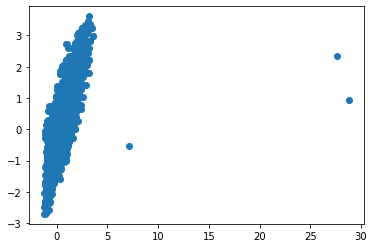

In [33]:
plt.scatter(preds[:,0],y[:,0])

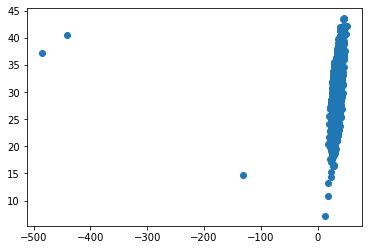

In [34]:
plt.scatter(preds[:,1],y[:,1])